<h1>Sieci neuronowe - ćwiczenie 2</h1>

In [ ]:
!pip install ucimlrepo

In [353]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

In [ ]:
def sigmoid(n: int) -> float:
    return 1 / (1 + np.exp(-n))

In [358]:
class LogarithmicRegression:
    _weights: np.ndarray
    _bias: float

    def __init_weights(self, size: int) -> np.ndarray:
        return np.random.rand(size, 1)
    
    def __gradient_weights(self, weights: np.ndarray, x: np.ndarray, y:np.ndarray, bias:float) -> np.ndarray:
        return -np.dot(x.T, (y - sigmoid(np.dot(x, weights) + bias))) / x.shape[0]
    
    def __gradient_bias(self, weights: np.ndarray, x: np.ndarray, y:np.ndarray, bias:float) -> np.ndarray:
        return np.sum(-(y - sigmoid(np.dot(x, weights) + bias))) / x.shape[0]
    
    def __cross_entropy_loss(self, weights: np.ndarray, x: np.ndarray, y:np.ndarray, bias:float) -> np.ndarray:
        return np.sum(-y*np.log(sigmoid(np.dot(x, weights) + bias)) - (1 - y)*np.log(1 - sigmoid(np.dot(x, weights) + bias))) / x.shape[0]
    
    def __optimize(self, x_train: np.ndarray, y_train: np.ndarray, x_test: np.ndarray, y_test: np.ndarray, learning_rate: float, 
                       min_step: float, max_iter: int) -> (list, list, list, list, list, list):
        losses = []
        weights = []
        biases = []

        accuracy = []
        f_score = []
        precision = []
        for _ in range(max_iter):
            step = learning_rate * self.__gradient_weights(self._weights, x_train, y_train, self._bias)
            if min_step is not None and (np.abs(step) <= min_step).any():
                break

            self._weights = self._weights - step
            self._bias = self._bias - self.__gradient_bias(self._weights, x_train, y_train, self._bias)

            losses.append(self.__cross_entropy_loss(self._weights, x_train, y_train, self._bias))
            weights.append(self._weights)
            biases.append(self._bias)

            y_pred = self.predict(x_test)
            accuracy.append(metrics.accuracy_score(y_test, y_pred))
            f_score.append(metrics.f1_score(y_test, y_pred))
            precision.append(metrics.precision_score(y_test, y_pred))

        return losses, weights, biases, accuracy, f_score, precision

    def logarithmicRegression(self, x_train: np.ndarray, y_train: np.ndarray, x_test: np.ndarray, y_test: np.ndarray, learning_rate: float, 
                       max_iter: int, min_step: float = None) -> (list, list, list, list, list, list):
        self._weights = self.__init_weights(x_train.shape[1])
        self._bias = np.random.rand()   
        
        losses, weights, biases, accuracy, f_score, precision = self.__optimize(x_train, y_train, x_test, y_test, learning_rate, min_step, max_iter)

        return losses, weights, biases, accuracy, f_score, precision

    def predict(self, x_test: np.ndarray) -> np.ndarray:
        y_pred = sigmoid(np.dot(x_test, self._weights) + self._bias)

        y_pred[y_pred >= 0.5] = 1
        y_pred[y_pred < 0.5] = 0
        
        return y_pred

        

In [179]:
# original code from https://archive.ics.uci.edu/dataset/45/heart+disease
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
heart_disease = fetch_ucirepo(id=45) 
  
# data (as pandas dataframes) 
heart_data = heart_disease.data.original

In [180]:
df: pd.DataFrame = heart_data

# repearing of the inbalnace in classification and removing null values
df["num"] = df["num"].replace([2, 3, 4], 1) #change classes to binary classification
print(df["num"].value_counts())

#get null values of ca and remove them
null_idx = df[df["ca"].isnull()].index 
print(null_idx)
df = df.drop(null_idx)
df = df.reset_index(drop=True) 
print(df["num"].value_counts())

#get null values of thel and remove them
null_idx = df[df["thal"].isnull()].index 
print(null_idx)
df = df.drop(null_idx)
df = df.reset_index(drop=True) 
print(df["num"].value_counts())

# balance classes to same amount 138
random_idx = df.query("num == 0").sample(df["num"].value_counts()[0] - df["num"].value_counts()[1]).index 
df = df.drop(random_idx)
df = df.reset_index(drop=True)
print(df["num"].value_counts())

df_without_num = df.loc[:, df.columns != "num"]
std_features = (df_without_num - df_without_num.mean() )/ df_without_num.std() #(value-mean)/variance

result = std_features
result["heart_disease"] = df["num"]

result

num
0    164
1    139
Name: count, dtype: int64
Index([166, 192, 287, 302], dtype='int64')
num
0    161
1    138
Name: count, dtype: int64
Index([87, 264], dtype='int64')
num
0    160
1    137
Name: count, dtype: int64
num
0    137
1    137
Name: count, dtype: int64


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,heart_disease
0,0.914820,0.669398,-2.213663,0.743636,-0.268875,2.450235,0.969497,0.039438,-0.715498,1.014703,2.261433,-0.741899,0.620982,0
1,1.361034,0.669398,0.839409,1.581679,0.736948,-0.406635,0.969497,-1.775953,1.392528,0.341306,0.635100,2.401612,-0.921154,1
2,1.361034,0.669398,0.839409,-0.653103,-0.344786,-0.406635,0.969497,-0.868258,1.392528,1.267226,0.635100,1.353775,1.135027,1
3,-1.985571,0.669398,-0.178282,-0.094407,0.053747,-0.406635,-1.042944,1.638710,-0.715498,2.024797,2.261433,-0.741899,-0.921154,0
4,-1.539357,-1.488427,-1.195972,-0.094407,-0.819231,-0.406635,0.969497,0.990356,-0.715498,0.257132,-0.991232,-0.741899,-0.921154,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269,0.245499,-1.488427,0.839409,0.464288,-0.117053,-0.406635,-1.042944,-1.127599,1.392528,-0.752963,0.635100,-0.741899,1.135027,1
270,-1.093143,0.669398,-2.213663,-1.211798,0.319436,-0.406635,-1.042944,-0.738587,-0.715498,0.088783,0.635100,-0.741899,1.135027,1
271,1.472588,0.669398,0.839409,0.687766,-1.027986,2.450235,-1.042944,-0.349575,-0.715498,1.940623,0.635100,1.353775,1.135027,1
272,0.245499,0.669398,0.839409,-0.094407,-2.204609,-0.406635,-1.042944,-1.473388,1.392528,0.088783,0.635100,0.305938,1.135027,1


In [249]:
def train_test_split(features, targets, percentage):
    choices = np.random.choice(range(features.shape[0]), size=(int(features.shape[0] * percentage/100),), replace=False) 
    split = np.zeros(features.shape[0], dtype=bool)
    split[choices] = True

    return features[split], targets[split], features[~split], targets[~split]

In [391]:
features = result.loc[:, result.columns != "heart_disease"].to_numpy()
targets = result["heart_disease"].to_numpy()[np.newaxis].T

x_train, y_train, x_test, y_test = train_test_split(features, targets, 70)

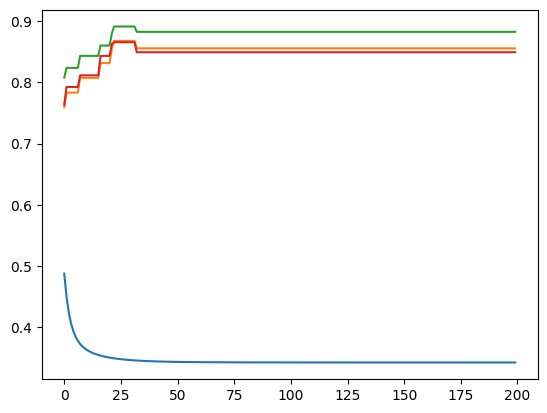

12


In [413]:
max_iter = 200

ex1 = LogarithmicRegression()

losses, weights, biases, accuracy, f_score, precision = ex1.logarithmicRegression(x_train, y_train, x_test, y_test, 0.9, max_iter)

plt.plot(np.arange(max_iter), losses)
plt.plot(np.arange(max_iter), accuracy)
plt.plot(np.arange(max_iter), f_score)
plt.plot(np.arange(max_iter), precision)
plt.show()

y_pred = ex1.predict(x_test)

index = 0
count = 0
for val in y_test:
    if(val != y_pred[index]):
        count += 1
    index += 1
print(count)


In [350]:
test = np.array([0.2, 0.6, 0.5])
test[test >= 0.5] = 1
test[test < 0.5] = 0
test

array([0., 1., 1.])